<a href="https://colab.research.google.com/github/mephi82/grad_data_analysis/blob/main/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon #Reparametrization: 평균 +  sigma * N(0,1)


## Build the encoder

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# 앞에까지는 layer 를 공유하고 마지막에 평균과 log_var로 갈라짐
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Build the decoder

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a `Model` with a custom `train_step`

In [5]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #x로부터 z의 평균, 분산 계산 -> latent z 추출(sample)
            reconstruction = self.decoder(z) #z로부터 x추측
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2) #x와 x추측값의 cross-entropy(=error)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) #z분포와 N(0,I)의 KL distance -> regularization
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [6]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 23s 19ms/step - loss: 251.4539 - reconstruction_loss: 200.5153 - kl_loss: 3.6099
Epoch 2/30
547/547 [==============================] - 10s 19ms/step - loss: 167.1155 - reconstruction_loss: 159.8870 - kl_loss: 5.0927
Epoch 3/30
547/547 [==============================] - 10s 19ms/step - loss: 160.6336 - reconstruction_loss: 154.3787 - kl_loss: 5.4248
Epoch 4/30
547/547 [==============================] - 10s 19ms/step - loss: 157.8215 - reconstruction_loss: 151.9733 - kl_loss: 5.5984
Epoch 5/30
547/547 [==============================] - 10s 19ms/step - loss: 156.0686 - reconstruction_loss: 150.3793 - kl_loss: 5.6830
Epoch 6/30
547/547 [==============================] - 10s 19ms/step - loss: 155.5415 - reconstruction_loss: 149.2408 - kl_loss: 5.7609
Epoch 7/30
547/547 [==============================] - 10s 19ms/step - loss: 154.1568 - reconstruction_loss: 148.3377 - kl_los

## Display a grid of sampled digits

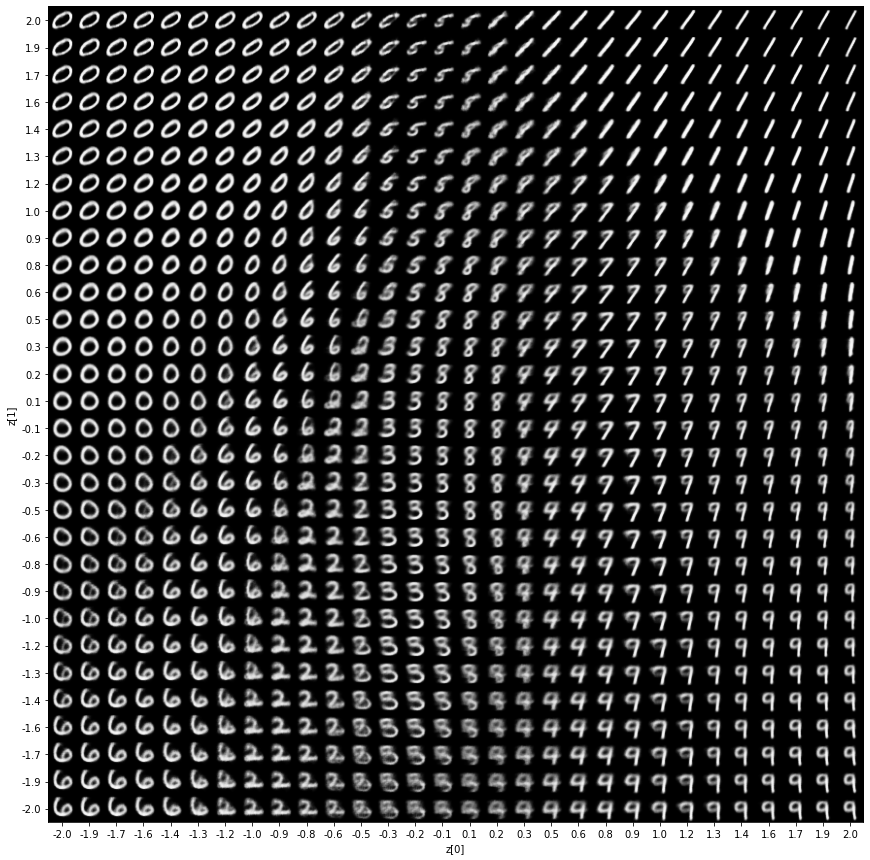

In [22]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

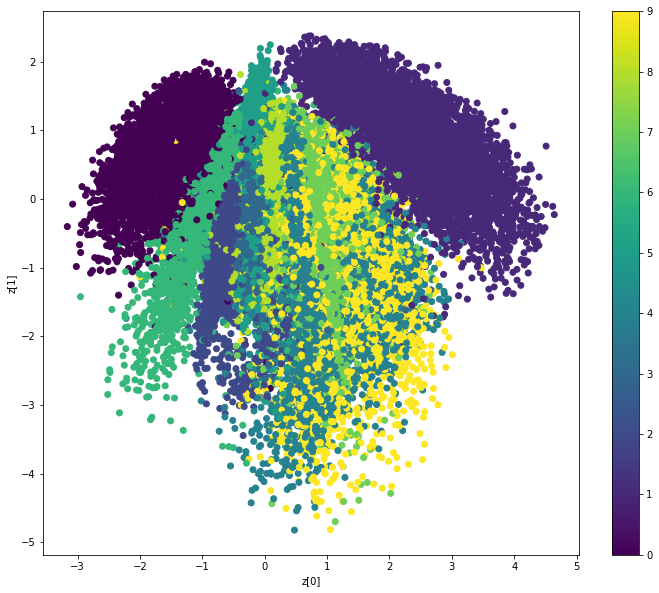

In [8]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

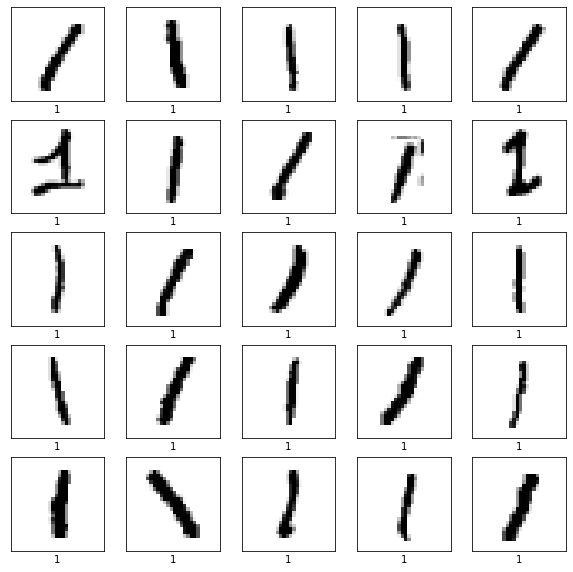

In [25]:
plt.figure(figsize=(10,10))
x=1
for i in np.where(y_train ==1)[0][:25]:
    plt.subplot(5,5,x)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
    x+=1
plt.show()

In [18]:
[i for i in np.where(y_train==1)[0]]
# np.where(y_train==1)[0][0]

[3,
 6,
 8,
 14,
 23,
 24,
 40,
 59,
 67,
 70,
 72,
 77,
 78,
 99,
 102,
 104,
 105,
 112,
 113,
 124,
 128,
 134,
 152,
 174,
 177,
 184,
 200,
 201,
 205,
 208,
 211,
 224,
 231,
 248,
 251,
 269,
 270,
 276,
 290,
 309,
 310,
 315,
 345,
 351,
 355,
 357,
 358,
 366,
 382,
 394,
 397,
 398,
 406,
 408,
 416,
 443,
 447,
 450,
 454,
 455,
 466,
 470,
 475,
 484,
 491,
 492,
 507,
 508,
 510,
 533,
 535,
 538,
 552,
 553,
 556,
 572,
 573,
 587,
 593,
 604,
 609,
 618,
 637,
 638,
 648,
 671,
 676,
 678,
 691,
 698,
 710,
 711,
 738,
 747,
 765,
 779,
 780,
 783,
 809,
 821,
 833,
 835,
 838,
 870,
 871,
 891,
 905,
 919,
 920,
 941,
 951,
 959,
 961,
 978,
 982,
 993,
 1002,
 1003,
 1012,
 1017,
 1031,
 1044,
 1051,
 1052,
 1060,
 1065,
 1069,
 1080,
 1081,
 1084,
 1085,
 1095,
 1115,
 1118,
 1123,
 1131,
 1132,
 1148,
 1155,
 1174,
 1181,
 1192,
 1197,
 1200,
 1211,
 1230,
 1238,
 1242,
 1243,
 1252,
 1259,
 1277,
 1287,
 1293,
 1321,
 1331,
 1354,
 1365,
 1369,
 1375,
 1394,
 1405,